### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [2]:
# Create a Kaggle API client
import os
os.environ['KAGGLE_USERNAME'] = 'mustabshiribnamin'
os.environ['KAGGLE_KEY'] = '0eff4183442e547cfe97d8be3e922d42' 
import kaggle as kg
kg.api.dataset_download_files(dataset = "bhavikjikadara/fake-news-detection", path='dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection


### View Data

In [3]:
true_df = pd.read_csv('dataset/true.csv')
fake_df = pd.read_csv('dataset/fake.csv')

In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


### Data Preprocessing

In [8]:
true_df.duplicated().sum()

206

In [9]:
true_df.drop_duplicates(inplace=True)

In [10]:
fake_df.duplicated().sum()

3

In [11]:
fake_df.drop_duplicates(inplace=True)

In [12]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [13]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [14]:
# labeling the true and false state
true_df['label'] = 0
fake_df['label'] = 1

In [15]:
# concating true and fake data
df = pd.concat([fake_df, true_df], ignore_index=True)
# shuffling the rows of the DataFrame and resetting the index
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
#replace underscores and making title format
df.columns = df.columns.str.replace('_', ' ').str.title()

In [17]:
df.head()

,Title,Text,Subject,Date,Label
0,Queen Declares RNC’s Use Of Their Music Was U...,"Yesterday, on the first day of the Republican ...",News,"July 19, 2016",1
1,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,worldnews,"December 27, 2017",0
2,French businesses seek clarity on Iran nuclear...,PARIS (Reuters) - French businesses and foreig...,worldnews,"October 20, 2017",0
3,HACKING DEMOCRACY? CIA Accusing Russia of Doin...,Peter Certo Other WordsEven in an election yea...,Middle-east,"January 3, 2017",1
4,U.N. political affairs chief to visit North Ko...,UNITED NATIONS (Reuters) - The United Nations ...,worldnews,"December 4, 2017",0


In [18]:
# Clean text
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    # remove text within square brackets
    text = re.sub('\[.*?\]', '', text) 
    # remove http links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove html tags
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove newline chars
    text = re.sub('\n', '', text)
    # remove all word containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # remove stopwords
    text = [word for word in text.split(' ') if word not in stopword]
    # applies stemming to words
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

df['Text'] = df['Text'].apply(lambda x: clean(x))
df['Title'] = df['Title'].apply(lambda x: clean(x))

In [19]:
df.head()

,Title,Text,Subject,Date,Label
0,queen declar rnc’ use music unauthor,yesterday first day republican nation convent ...,News,"July 19, 2016",1
1,nigeria say us agre delay million fighter pla...,abuja reuter unit state formal agre sell sup...,worldnews,"December 27, 2017",0
2,french busi seek clariti iran nuclear deal,pari reuter french busi foreign financ minist...,worldnews,"October 20, 2017",0
3,hack democraci cia accus russia langley well,peter certo wordseven elect year shot conspira...,Middle-east,"January 3, 2017",1
4,un polit affair chief visit north korea week,unit nation reuter unit nation polit affair ...,worldnews,"December 4, 2017",0


### Sentiment Analysis

In [20]:
sia = SentimentIntensityAnalyzer()
result = {}

for i, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis"):
    text = row['Text']
    my_id = row['Title'] 
    result[my_id] = sia.polarity_scores(text)

Sentiment Analysis:   0%|          | 0/44689 [00:00<?, ?it/s]

In [21]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Title'})
vaders = vaders.merge(df, how='left')

In [22]:
vaders.head()

,Title,neg,neu,pos,compound,Text,Subject,Date,Label
0,queen declar rnc’ use music unauthor,0.139,0.747,0.114,-0.8481,yesterday first day republican nation convent ...,News,"July 19, 2016",1
1,nigeria say us agre delay million fighter pla...,0.096,0.779,0.126,0.7096,abuja reuter unit state formal agre sell sup...,worldnews,"December 27, 2017",0
2,french busi seek clariti iran nuclear deal,0.000,0.935,0.065,0.9136,pari reuter french busi foreign financ minist...,worldnews,"October 20, 2017",0
3,hack democraci cia accus russia langley well,0.094,0.811,0.095,-0.4019,peter certo wordseven elect year shot conspira...,Middle-east,"January 3, 2017",1
4,hack democraci cia accus russia langley well,0.094,0.811,0.095,-0.4019,peter certo wordseven elect year shot conspira...,US_News,"January 3, 2017",1


### Model Training

In [23]:
from imblearn.over_sampling import RandomOverSampler
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix



In [24]:
df1 = vaders.copy()

In [25]:
df1['content'] = df1['Title'] + ' ' + df1['Text']

In [26]:
X = df1['content']
y = df1['Label']

In [27]:
# Scaling "Label" oversampling for balanced class distribution
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df1['content'].values.reshape(-1, 1), df1['Label'])
X_res = X_res.flatten()

In [28]:
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='OOV')
tokenizer.fit_on_texts(X_res)
sequences = tokenizer.texts_to_sequences(X_res)
padded = pad_sequences(sequences, maxlen=1000)

In [29]:
# Save the tokenizer
with open('Models/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, y_res, test_size=0.2, random_state=42)

In [31]:
model = keras.Sequential()

# converts integer-encoded word indices (from the tokenized text) into dense vectors of fixed size
model.add(keras.layers.Embedding(input_dim=10000, output_dim=32))  
model.add(keras.layers.SimpleRNN(32, activation='relu', dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.keras', monitor='val_loss', save_best_only=True)

history1 = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

Epoch 1/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - accuracy: 0.7836 - loss: 305.8301 - val_accuracy: 0.8884 - val_loss: 0.2850
Epoch 2/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.8969 - loss: 0.2675 - val_accuracy: 0.8999 - val_loss: 0.2348
Epoch 3/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.9134 - loss: 0.2191 - val_accuracy: 0.9088 - val_loss: 0.2118
Epoch 4/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - accuracy: 0.9261 - loss: 0.1868 - val_accuracy: 0.9133 - val_loss: 0.1992
Epoch 5/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.9375 - loss: 0.1615 - val_accuracy: 0.9175 - val_loss: 0.1920
Epoch 6/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.9400 - loss: 0.1542 - val_accuracy: 0.9193 - val_loss: 0.1865
Epoch 7/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.9440 - loss: 0.1396 - val_accuracy: 0.9218 - val_loss: 0.1826
Epoch 8/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy

In [33]:
evaluation_result = model.evaluate(X_test, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9348 - loss: 0.1639
Test Loss: 0.17542316019535065
Test Accuracy: 0.9306856989860535


In [34]:
y_pred = model.predict(X_test)

y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Classification Report (includes precision, recall, F1-score per class)
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4690
           1       0.93      0.93      0.93      4702

    accuracy                           0.93      9392
   macro avg       0.93      0.93      0.93      9392
weighted avg       0.93      0.93      0.93      9392

[[4364  326]
 [ 325 4377]]


In [35]:
print(accuracy)
print(precision)
print(recall)
print(f"F1 Score: {f1:.4f}")

0.9306856899488927
0.9306825430576228
0.9308804763930243
F1 Score: 0.9308


In [36]:
model.summary()
model.save('simple_rnn_model.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 32)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,341 (3.69 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 644,228 (2.46 MB)

In [37]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=10000, output_dim=32))
model_lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model_lstm.add(keras.layers.Dropout(0.5))
model_lstm.add(keras.layers.LSTM(32))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.01)))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_lstm_checkpoint = keras.callbacks.ModelCheckpoint('model_lstm.{epoch:02d}-{val_loss:.2f}.keras', monitor='val_loss', save_best_only=True)

history2 = model_lstm.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

Epoch 1/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 263s 222ms/step - accuracy: 0.9151 - loss: 0.2287 - val_accuracy: 0.9549 - val_loss: 0.2126
Epoch 2/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 265s 226ms/step - accuracy: 0.9790 - loss: 0.0820 - val_accuracy: 0.9964 - val_loss: 0.0305
Epoch 3/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 260s 222ms/step - accuracy: 0.9979 - loss: 0.0252 - val_accuracy: 0.9963 - val_loss: 0.0283
Epoch 4/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 389s 331ms/step - accuracy: 0.9973 - loss: 0.0239 - val_accuracy: 0.9944 - val_loss: 0.0335
Epoch 5/100
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 279s 238ms/step - accuracy: 0.9981 - loss: 0.0242 - val_accuracy: 0.9920 - val_loss: 0.0442


In [39]:
evaluation_result = model_lstm.evaluate(X_test, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9964 - loss: 0.0285
Test Loss: 0.028275178745388985
Test Accuracy: 0.996273398399353


In [40]:
y_pred = model_lstm.predict(X_test)

y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Classification Report (includes precision, recall, F1-score per class)
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4690
           1       1.00      1.00      1.00      4702

    accuracy                           1.00      9392
   macro avg       1.00      1.00      1.00      9392
weighted avg       1.00      1.00      1.00      9392

[[4678   12]
 [  23 4679]]


In [41]:
print(accuracy)
print(precision)
print(recall)
print(f"F1 Score: {f1:.4f}")

0.9962734241908007
0.9974419100405031
0.9951084644831987
F1 Score: 0.9963


In [42]:
model_lstm.summary()
model_lstm.save('lstm_model.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 32)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1000, 64)       │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,269 (4.00 MB)

 Trainable params: 349,089 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 698,180 (2.66 MB)

### Result Analysis Plots

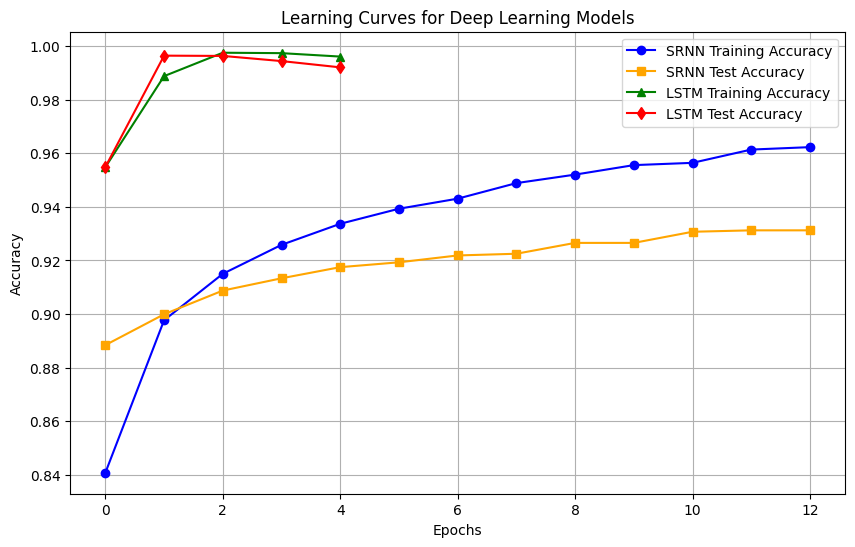

In [45]:
import matplotlib.pyplot as plt


# Plot learning curves for both models
plt.figure(figsize=(10, 6))

# Plot model1's learning curves
plt.plot(history1.history['accuracy'], label="SRNN Training Accuracy", marker='o', color='blue')
plt.plot(history1.history['val_accuracy'], label="SRNN Test Accuracy", marker='s', color='orange')

# Plot model2's learning curves
plt.plot(history2.history['accuracy'], label="LSTM Training Accuracy", marker='^', color='green')
plt.plot(history2.history['val_accuracy'], label="LSTM Test Accuracy", marker='d', color='red')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curves for Deep Learning Models")
plt.legend()
plt.grid()
plt.show()